In [79]:
import torch
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


In [80]:
# # Download training data from open datasets.
# training_data = datasets.FashionMNIST(
#     root="data",
#     train=True,
#     download=True,
#     transform=ToTensor(),
# )

# # Download test data from open datasets.
# test_data = datasets.FashionMNIST(
#     root="data",
#     train=False,
#     download=True,
#     transform=ToTensor(),
# )

from torchvision import transforms

# Define a chain of transformations
train_transforms = transforms.Compose([
    # transforms.RandomHorizontalFlip(), # Randomly flips images horizontally
    # transforms.RandomRotation(10),     # Randomly rotates images by up to 10 degrees
    # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor()
])

# Apply these transforms ONLY to the training data
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=train_transforms, # Use the new transforms here
)

# Test data should not be augmented
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [81]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [82]:
print(training_data.data.shape)
print(test_data.data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


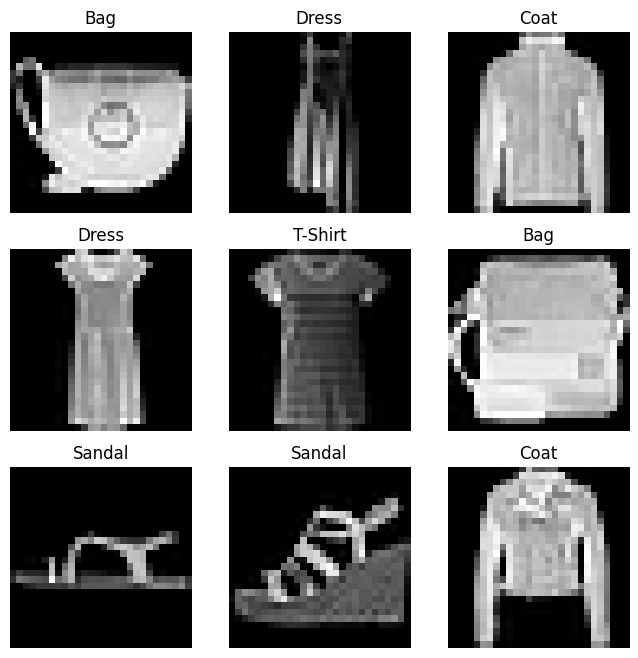

In [83]:

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [84]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten() #flatten the input into single vector
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),nn.ReLU(),
            nn.Linear(512, 512), nn.BatchNorm1d(512),nn.ReLU(),
            nn.Linear(512, 512), nn.ReLU(),nn.Dropout(0.5),
            nn.Linear(512, 512), nn.BatchNorm1d(512),nn.ReLU(),
            nn.Linear(512, 10)
        )
        # self.linear_relu_stack = nn.Sequential(
        # nn.Linear(28*28, 768), nn.ReLU(),
        # nn.Linear(768, 768), nn.BatchNorm1d(768), nn.ReLU(),
        # nn.Dropout(0.5), # Added a dropout layer here
        # nn.Linear(768, 512), nn.ReLU(),
        # nn.Dropout(0.5),
        # nn.Linear(512, 512), nn.BatchNorm1d(512), nn.ReLU(),
        # nn.Linear(512, 10)
        # )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=512, bias=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=512, out_features=512, bias=True)
    (9): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [85]:
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=10e-4, weight_decay=1e-5)
# optimizer = torch.optim.Adam(model.parameters(), lr=10e-6, weight_decay=1e-4)
optimizer = torch.optim.AdamW(model.parameters(), lr=3*10e-6, weight_decay=1e-3)
# scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=2)

In [86]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [87]:
# def test(dataloader, model, loss_fn):
#     size = len(dataloader.dataset)
#     num_batches = len(dataloader)
#     model.eval()
#     test_loss, correct = 0, 0
#     with torch.no_grad():
#         for X, y in dataloader:
#             X, y = X.to(device), y.to(device)
#             pred = model(X)
#             test_loss += loss_fn(pred, y).item()
#             correct += (pred.argmax(1) == y).type(torch.float).sum().item()
#     test_loss /= num_batches
#     correct /= size
#     print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    # return test_loss

In [88]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
    # scheduler.step(test_loss)
print("Done!")

Epoch 1
-------------------------------
loss: 2.386792  [   64/60000]
loss: 1.170115  [ 6464/60000]
loss: 0.654556  [12864/60000]
loss: 0.822566  [19264/60000]
loss: 0.672612  [25664/60000]
loss: 0.556570  [32064/60000]
loss: 0.547695  [38464/60000]
loss: 0.614082  [44864/60000]
loss: 0.598647  [51264/60000]
loss: 0.516355  [57664/60000]
Test Error: 
 Accuracy: 84.2%, Avg loss: 0.449426 

Epoch 2
-------------------------------
loss: 0.396711  [   64/60000]
loss: 0.472864  [ 6464/60000]
loss: 0.320603  [12864/60000]
loss: 0.516631  [19264/60000]
loss: 0.443433  [25664/60000]
loss: 0.443697  [32064/60000]
loss: 0.320072  [38464/60000]
loss: 0.435417  [44864/60000]
loss: 0.442794  [51264/60000]
loss: 0.441025  [57664/60000]
Test Error: 
 Accuracy: 86.2%, Avg loss: 0.384517 

Epoch 3
-------------------------------
loss: 0.366901  [   64/60000]
loss: 0.400926  [ 6464/60000]
loss: 0.264574  [12864/60000]
loss: 0.385164  [19264/60000]
loss: 0.306128  [25664/60000]
loss: 0.364015  [32064/600

In [89]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [90]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [91]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[10][0], test_data[10][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Coat", Actual: "Coat"


In [92]:
import os
model_size = os.path.getsize("model.pth") / (1024 * 1024)
print(f"Size of the final model: {model_size:.2f} MB")

Size of the final model: 4.58 MB
